# CNN CIFAR10 v2

- 1. CIFAR 10 데이터 로드 및 정규화
- 2. CIFAR 10 데이터 증강 (ImageDataGenerator 사용)
- 3. CNN 모델 구축 (7 Conv Layer, 5 polling Layer)
- 4. CNN 모델 컴파일 및 학습
- 5. CNN 성능향상 측정 (정확도↑, 오버피팅↓)

## 1. CIFAR-10 데이터 불러오기 및 정규화

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. CIFAR 10 데이터 보강 (150% 증대)

In [2]:
gen = ImageDataGenerator(rotation_range=20,
                         shear_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True)

In [3]:
# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
                                      # 데이터 불러오기

x_train = x_train.astype(np.float32) / 255.0  # 정규화
x_test = x_test.astype(np.float32) / 255.0

In [4]:
# 보강할 학습데이터 이미지 생성

augment_ratio = 1.5   # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

print(augment_size)

# 전체 x_train 개수의 150% 비율만큼
randidx = np.random.randint(x_train.shape[0], size=augment_size)

# 임의로 선택된 데이터는 원본데이터를 참조하기 때문에
# 원본데이터에 영향을 줄수 있음. 그래서 copy() 함수를 통해 안전하게 복사본 만듬
x_augmented = x_train[randidx].copy() 
y_augmented = y_train[randidx].copy()

print(x_augmented.shape, y_augmented.shape)

#  이미지 보강 실행
x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, 
                          # 보강할 이미지 데이터 생성
                                    batch_size=augment_size,
                                    shuffle=False).next()

print(x_augmented.shape, y_augmented.shape)

75000
(75000, 32, 32, 3) (75000, 1)
(75000, 32, 32, 3) (75000, 1)


In [5]:
# x_train, y_train 에 보강된 데이터 추가

x_train = np.concatenate( (x_train, x_augmented) )
y_train = np.concatenate( (y_train, y_augmented) )

#s = np.arange(x_train.shape[0])
#np.random.shuffle(s)
#x_traion = x_train[s]
#y_train = y_train[s]
## 보강된 학습 데이터, 정답 데이터를 랜덤하게 섞음

print(x_train.shape, y_train.shape)

(125000, 32, 32, 3) (125000, 1)


## 3. CNN 모델 구축

In [6]:
cnn=Sequential()

cnn.add(Conv2D(32,(3,3),activation='relu', padding='same',input_shape=(32,32,3)))
cnn.add(Conv2D(32,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
# 첫번째 블럭 구성
# 3x3 크기의 필터 32개를 가진 2개의 컨볼루션 층과 한 개의 맥스풀링 층

cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
# 두번째 블럭 구성
# 3x3 크기의 필터 64개를 가진 2개의 컨볼루션 층과 한 개의 맥스풀링 층

cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(256,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
# 마지막 블럭 구성
# 컨볼루션층과 맥스풀링층을 순서대로 차곡차곡 쌓아서 구성
# 128 -> 128 -> 256   점차 증가

cnn.add(Flatten()) # 3차원 텐서를 1차원 벡터로 변환

cnn.add(Dense(128,activation='relu')) # 은닉층 개념
cnn.add(Dropout(0.5))
cnn.add(Dense(10,activation='softmax')) # 출력층

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                        

## 4. CNN 모델 컴파일 및 학습

In [7]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

hist = cnn.fit(x_train, y_train, batch_size=256, 
               epochs=25, validation_data=(x_test, y_test))

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/25
489/489 [==============================] - 240s 489ms/step - loss: 1.7864 - accuracy: 0.3315 - val_loss: 1.4215 - val_accuracy: 0.4806
Epoch 2/25
489/489 [==============================] - 238s 486ms/step - loss: 1.3558 - accuracy: 0.5121 - val_loss: 1.0794 - val_accuracy: 0.6097
Epoch 3/25
489/489 [==============================] - 238s 486ms/step - loss: 1.1721 - accuracy: 0.5861 - val_loss: 0.8970 - val_accuracy: 0.6823
Epoch 4/25
489/489 [==============================] - 238s 487ms/step - loss: 1.0499 - accuracy: 0.6315 - val_loss: 0.8468 - val_accuracy: 0.6985
Epoch 5/25
489/489 [==============================] - 238s 487ms/step - loss: 0.9682 - accuracy: 0.6652 - val_loss: 0.7360 - val_accuracy: 0.7410
Epoch 6/25
489/489 [==============================] - 239s 489ms/step - loss: 0.9103 - accuracy: 0.6867 - val_loss: 0.6779 - val_accuracy: 0.7583
Epoch 7/25
489/489 [==============================] - 250s 511ms/step - loss: 0.8635 - accuracy: 0.7047 - val_loss: 0.6985 -

In [8]:
cnn.evaluate(x_test, y_test)

313/313 [==============================] - 5s 16ms/step - loss: 0.4925 - accuracy: 0.8317


[0.4924844801425934, 0.8317000269889832]

## 5. 정확도 및 손실

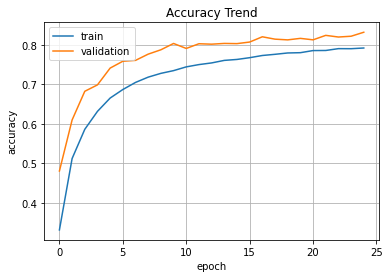

In [9]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()

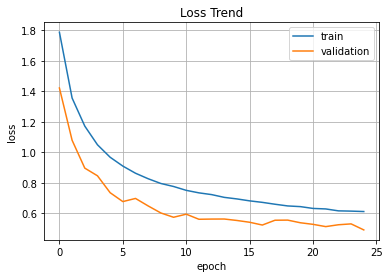

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()

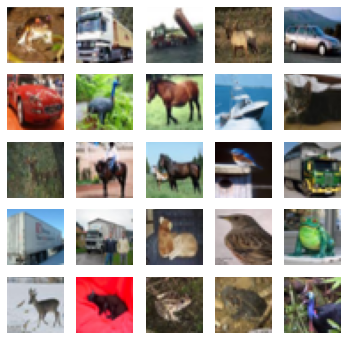

In [11]:
# 25개의 이미지 출력
plt.figure(figsize=(6,6))

for index in range(25):   # 25 개 이미지 출력
    plt.subplot(5,5, index + 1) # 5행 5열
    plt.imshow(x_train[index], cmap='gray')
    plt.axis('off')
    
plt.show()

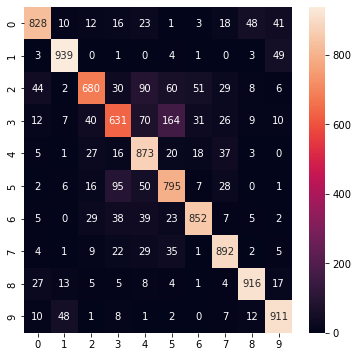

In [12]:
from sklearn. metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(6,6))
predicted_value = cnn.predict(x_test)
cm = confusion_matrix(y_test, np.argmax(predicted_value, axis=-1))
    # y_test - 테스트 데이터 정답 (10진수) [원핫 인코딩이 아니기 때문]
    # 예측값(predicted_value) - softmax에 의해 10개의 노드로 출력됨
    # numpy의 argmax를 통해 가장 높은 값의 노드로 출력됨.
    
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

### 시간관계상 25번만 시행했으나 250번 시행했을 때의 결과

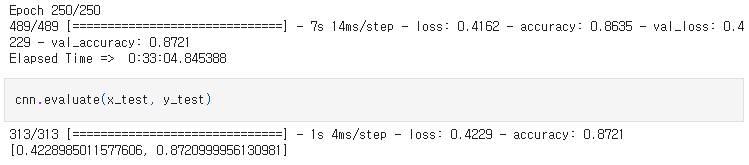

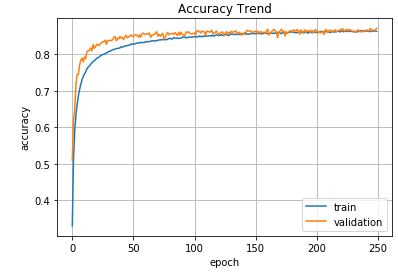

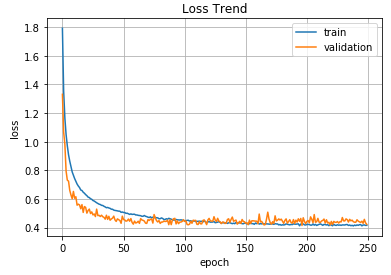